# AIAP Batch 15 Technical Assessment
**Full Name**: Lim Jun Ming  
**Email**: billy.ljm@gmail.com  

In [1]:
import warnings

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import Levenshtein

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import src.datapipeline

sns.set_theme()
pd.set_option('display.max_column', None)
warnings.filterwarnings("ignore", category=FutureWarning)

# 0. Data Reading
<sub>We were instructed to remove the SQL databases from our submission, so you have to add them back before re-running this ipynb.</sub>  

There are two SQL databases provided, in `./data/cruise_pre.db` and `./data/cruise_post.db`.
The description of the attributes in each of these databases are provided in the 

In [2]:
# read pre data
con_pre = sqlite3.connect("data/cruise_pre.db")
df_pre = pd.read_sql('SELECT * FROM cruise_pre', con_pre)
con_pre.close()
df_pre.head()

,index,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
0,0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


In [3]:
# read post_data
con_post = sqlite3.connect("data/cruise_post.db")
df_post = pd.read_sql('SELECT * FROM cruise_post', con_post)
con_post.close()
df_post.head()

,index,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
0,0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,4,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


# 1. Data Cleaning
In this section, I'll clean the SQL database, correcting any typos, changing the data types to better suit the column, etc.  

These data cleaning steps will be replicated in the final ML pipeline, since I don't have access to the copy of the database that will used in production.  

## 1.1. Duplicate Ext_Intcode
We want to use `Ext_Intcode` as the index, since it should be unique for each passenger.  

But it appears that several `Ext_Intcode` are duplicated across multiple rows in the database.  
Visual insepction reveals that these rows and mostly identical, with `Logging` columns that are too close to indicate repeat passengers.  
So, we'll drop these rows with duplicated `Ext_Intcode`, only keeping the row with the least NA values.  

In [4]:
def remove_dupl(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows with duplicate 'Ext_Intcode' from the cruise survey results
    The rows with the most non-NA values will be kept

    :param df: Pandas dataframe to remove duplicates from
    :return: Pandas dataframe with duplicate rows removed
    """
    df['counts'] = df.count(axis=1)
    df = df.sort_values(['Ext_Intcode', 'counts'])
    df = df.drop_duplicates('Ext_Intcode', keep='last')
    df = df.drop(columns=['index', 'counts'])
    df = df.set_index('Ext_Intcode')
    return df

remove_dupl(df_post).head()

,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,
BL100AELMIT,Blastoise,Luxury,150 KM,0.0,1,1.0
BL100AQXMUS,Blastoise,Luxury,1464 KM,1.0,0,1.0
BL100BAEEDV,Lapras,Standard,1733 KM,NaN,1,NaN
BL100CNCWCN,Blastoise,Luxury,None,1.0,0,0.0
BL100DHMSHK,Blastoise,Standard,862 KM,NaN,1,NaN


## 1.2. Combine Databases
Now that we have a unique identifier for each row across both databases,  
We can combine both databases into a single dataframe for easier management.

In [5]:
df = remove_dupl(df_pre)
df = df.join(remove_dupl(df_post))
df.tail()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,,,
LB999YYTHAL,Male,07/03/1995,Direct - Company Website,Not at all important,NaN,1.0,1.0,11/05/2023 14:41,Somewhat important,1.0,3.0,Somewhat important,3.0,4.0,NaN,4.0,3.0,Lapras,Standard,1069 KM,NaN,1,NaN
LB999ZAGTFL,Female,28/12/1994,Direct - Company Website,Not at all important,1.0,1.0,1.0,09/04/2023 7:36,Extremely important,5.0,5.0,Extremely important,4.0,NaN,3.0,4.0,5.0,IAPRAS,Luxury,3601 KM,1.0,0,1.0
LB999ZJGUVX,None,09/08/1976,Direct - Email Marketing,Very important,3.0,5.0,2.0,11/07/2023 8:53,Somewhat important,5.0,3.0,Somewhat important,NaN,3.0,NaN,3.0,NaN,blast0ise,Standard,2182 KM,NaN,0,NaN
LB999ZLRJKH,Female,18/11/1973,Direct - Email Marketing,Somewhat important,3.0,3.0,3.0,21/02/2023 8:01,Somewhat important,4.0,5.0,Very important,4.0,4.0,3.0,4.0,4.0,None,Luxury,3332 KM,0.0,1,0.0
LB999ZTNYSO,Female,24/06/1967,Direct - Company Website,Somewhat important,4.0,3.0,1.0,11/08/2023 14:32,Somewhat important,4.0,5.0,A little important,2.0,2.0,4.0,2.0,5.0,Lapras,Deluxe,-1073 KM,NaN,1,0.0


## 1.3. Overview
Now, we can look at a summary of the full dataset, taking note of which columns likely still need cleaning.  
From the summary below and from visual inspection, we will do the following

- `Onboard Wifi Service`, `Onboard Dining Service`, `Onboard Entertainment` should be converted to the same ordinal encoding as the other fields (which use the same rating scale).
- `Gate Location`, `Online Check-in` and similar columns have values of 0, which don't correspond to anything on the 4 point scale.  
  We'll regard these 0 values as null values for now.  
- `Cruise Distance` has units, and should be converted to a numerical field with a common unit.  
  And there are also negative distances (at ~6% of the rows), which we'll ignore as null values to be conservative.  
- `Cruise Name` has typos (e.g. blast0ise vs Blastoise)
- `Date of Birth` and `Logging` has inconsistent date formats (e.g. 01/01/2023 vs 2023-01-01)
- datatypes have to be fixed (e.g. datetime for `Date of Birth`, integers for `Gate location` and `WiFi`, etc)

In [6]:
df.describe(include='all')

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
count,116781,115565,129850,110926,114652.000000,112063.000000,113209.000000,129850,113509,114634.000000,113494.000000,114403,116396.000000,113453.000000,115904.000000,112099.000000,115344.000000,114404,110899,115773,62139.000000,129850.000000,71549.000000
unique,2,25746,4,5,NaN,NaN,NaN,108368,5,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,8,3,8995,NaN,NaN,NaN
top,Female,03/05/1984,Direct - Company Website,A little important,NaN,NaN,NaN,09/07/2023 18:30,Very important,NaN,NaN,Very important,NaN,NaN,NaN,NaN,NaN,Blastoise,Luxury,337 KM,NaN,NaN,NaN
freq,59175,21,53049,28511,NaN,NaN,NaN,6,26742,NaN,NaN,32368,NaN,NaN,NaN,NaN,NaN,67122,53088,652,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,3.055830,2.757369,2.978756,NaN,NaN,3.249935,3.439574,NaN,3.383209,3.633416,3.307064,3.641299,3.285745,NaN,NaN,NaN,0.500587,0.499345,0.502621
std,NaN,NaN,NaN,NaN,1.526339,1.402469,1.278190,NaN,NaN,1.350470,1.321604,NaN,1.287788,1.178899,1.266700,1.178621,1.313328,NaN,NaN,NaN,0.500004,0.500001,0.499997
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,2.000000,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,3.000000,3.000000,3.000000,2.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,3.000000,3.000000,3.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,4.000000,3.000000,4.000000,3.000000,NaN,NaN,NaN,1.000000,0.000000,1.000000
75%,NaN,NaN,NaN,NaN,4.000000,4.000000,4.000000,NaN,NaN,4.000000,5.000000,NaN,4.000000,5.000000,4.000000,5.000000,4.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000


## 1.4. 5-Star Ratings: Onboard Wifi Service, Gate location, etc
Cleaning the 5-star ordinal ratings of the 13 similar fields including `Onboard Wifi Service`, and `Gate location`,

In [7]:
df['Onboard Wifi Service'].unique()

array(['Not at all important', 'Somewhat important', None,
       'A little important', 'Extremely important', 'Very important'],
      dtype=object)

In [8]:
df['Gate location'].unique()

array([ 1.,  5.,  4.,  3.,  2., nan,  0.])

In [9]:
def clean_5star_rating(rating: str) -> int:
    """
    Converts a rating of 'Not at all important', 'A little important', 
    'Somewhat important', 'Very important', 'Extremely important' into a 
    ordinal 5-point scale

    :param rating: Pandas series to be converted
    :return: Pandas series converted to 5-point scale
    """
    scale_pre = {'Not at all important': 1, 'A little important': 2, 
                 'Somewhat important': 3, 'Very important': 4, 
                 'Extremely important': 5}
    
    if (pd.isnull(rating)): return rating
    elif (rating in scale_pre): return scale_pre[rating]
    elif (rating in scale_pre.values()): return rating
    else: return np.nan

pent_cols = ['Onboard Wifi Service', 'Embarkation/Disembarkation time convenient', # 4-point rating
             'Ease of Online booking', 'Gate location', 'Onboard Dining Service', 
             'Online Check-in', 'Cabin Comfort', 'Onboard Entertainment', 'Cabin service',
             'Baggage handling', 'Port Check-in Service', 'Onboard Service', 'Cleanliness']

for i in pent_cols:
    df[i] = df[i].apply(clean_5star_rating)
    
df['Onboard Wifi Service'].unique()

array([ 1.,  3., nan,  2.,  5.,  4.])

## 1.5 Cruise Distance
Converting cruise distance to numerical, in units of kilometre

In [10]:
df['Cruise Distance'].apply(lambda x: x.split(' ')[1] if pd.notnull(x) else x).unique()

array(['KM', None, 'Miles'], dtype=object)

In [11]:
def clean_distance(dist: str) -> int:
    """
    Converts a distance specified as "<number> <units>" (e.g. "50 Miles")
    into the number of kilometres

    :param dist: distance specified as "<number> <units>"
    :return: number of kilometres the distance corresponds to
    """
    if pd.isnull(dist): return dist # null values
    num, units = dist.split(' ')
    num = int(num)
    if (num <= 0): num = np.nan
    elif (units == "km" or units == "KM"): num *= 1
    elif (units == "Miles"): num *= 1.60934
    return num

df['Cruise Distance'] = df['Cruise Distance'].apply(clean_distance)
df['Cruise Distance'].head()

Ext_Intcode
BL100AELMIT     150.0
BL100AQXMUS    1464.0
BL100BAEEDV    1733.0
BL100CNCWCN       NaN
BL100DHMSHK     862.0
Name: Cruise Distance, dtype: float64

## 1.6 Cruise Name
Correcting the typos in cruise name.  

It appears that there are only 2 cruise ships, Blastoise and Lapras.  
So we'll correct the cruise names to the closest valid name based on the Levenshtein distance to each.  

In [12]:
df['Cruise Name'].unique()

array(['Blastoise', 'Lapras', None, 'blast0ise', 'blast', 'blastoise',
       'lapras', 'lap', 'IAPRAS'], dtype=object)

In [13]:
def clean_name(name: str, valid_names: list) -> str:
    """
    Maps a name onto a finite set of valid names, based on Levenshtein 
    distance

    :param name: name to map onto `valid_names`
    :param valid_names: list of names that `name` should map onto
    :return: the element of `valid_names` that is closest to `name`
    """
    if pd.isnull(name): return name # null value
    elif name in valid_names: return name # valid name
    else:
        dist = [Levenshtein.distance(name, i) for i in valid_names]
        return valid_names[dist.index(min(dist))]

df['Cruise Name'] = df['Cruise Name'].apply(lambda x: clean_name(x, ['Blastoise', 'Lapras']))
df['Cruise Name'].unique()

array(['Blastoise', 'Lapras', None], dtype=object)

## 1.7 Datetimes
We have to type cast datetimes of mixed formats.  
We'll tried using the inbuilt pandas `to_datetime` below, and checked if there are any significant errors that has to be addressed.  

- `Date of Birth` indicates a significant number of passengers was born before 1920, more than 100 years ago.  
  This is highly suspicious and visual inspection of the rows doesn't indicate any obvious ways to fix it.  
  Thus, we'll just ignore these suscipicous date of births, as null values.
- `Logging` has datetimes that are in the future.  
  Similarly, there is no clear way to correct them and I'll ignore dates later than 31 August 2023 as null values.

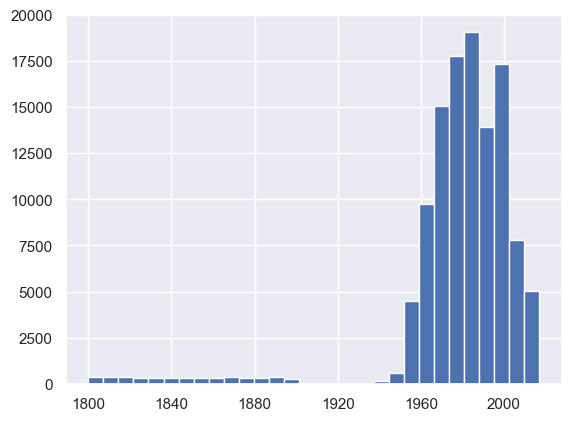

In [14]:
pd.to_datetime(df['Date of Birth'], format='mixed').hist(bins=30)
plt.show()

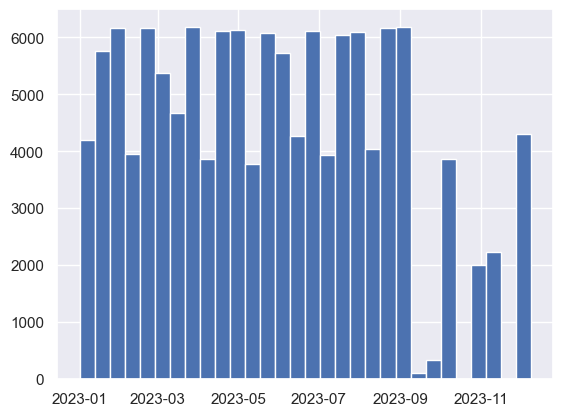

In [15]:
pd.to_datetime(df['Logging'], format='mixed').hist(bins=30)
plt.show()

In [16]:
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='mixed')
df['Date of Birth'] = df['Date of Birth'].apply(lambda x: x if x.year > 1920 else pd.NaT)

df['Logging'] = pd.to_datetime(df['Logging'], format='mixed')
df['Logging'] = df['Logging'].apply(lambda x: x if x.month < 9 and x.year <= 2023 else pd.NaT)

df[['Date of Birth', 'Logging']].head()

,Date of Birth,Logging
Ext_Intcode,,
BL100AELMIT,1967-02-17,NaT
BL100AQXMUS,2001-06-26,2023-03-23 14:52:00
BL100BAEEDV,NaT,2023-01-29 06:41:00
BL100CNCWCN,1964-10-22,2023-06-22 18:17:00
BL100DHMSHK,2002-09-05,2023-03-23 01:23:00


## 1.8 Data Types
Converting each column to the appropriate data type,

In [17]:
df = df.astype({
    'Gender': 'category', 
    'Date of Birth': 'datetime64[ns]', 
    'Source of Traffic': 'category', 
    'Onboard Wifi Service': 'Int64',
    'Embarkation/Disembarkation time convenient': 'Int64', 
    'Ease of Online booking': 'Int64',
    'Gate location': 'Int64', 
    'Logging': 'datetime64[ns]', 
    'Onboard Dining Service': 'Int64', 
    'Online Check-in': 'Int64',
    'Cabin Comfort': 'Int64', 
    'Onboard Entertainment': 'Int64', 
    'Cabin service': 'Int64',
    'Baggage handling': 'Int64', 
    'Port Check-in Service': 'Int64', 
    'Onboard Service': 'Int64',
    'Cleanliness': 'Int64', 
    'Cruise Name': 'category', 
    'Ticket Type': 'category', 
    'Cruise Distance': 'float64', 
    'WiFi': 'Int64',
    'Dining': 'Int64', 
    'Entertainment': 'Int64',
})

df

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,,,
BL100AELMIT,Male,1967-02-17,Direct - Email Marketing,1,1,<NA>,1,NaT,5,5,5,4,4,4,<NA>,4,3,Blastoise,Luxury,150.0,0,1,1
BL100AQXMUS,NaN,2001-06-26,Direct - Company Website,3,5,5,5,2023-03-23 14:52:00,<NA>,<NA>,3,3,4,3,2,3,3,Blastoise,Luxury,1464.0,1,0,1
BL100BAEEDV,Male,NaT,Direct - Email Marketing,<NA>,4,<NA>,1,2023-01-29 06:41:00,<NA>,<NA>,5,5,5,4,3,<NA>,5,Lapras,Standard,1733.0,<NA>,1,<NA>
BL100CNCWCN,Female,1964-10-22,Direct - Company Website,<NA>,<NA>,<NA>,5,2023-06-22 18:17:00,4,5,3,5,5,5,<NA>,5,1,Blastoise,Luxury,NaN,1,0,0
BL100DHMSHK,Female,2002-09-05,Indirect - Social Media,1,1,1,4,2023-03-23 01:23:00,<NA>,1,3,3,3,4,3,<NA>,3,Blastoise,Standard,862.0,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LB999YYTHAL,Male,1995-07-03,Direct - Company Website,1,<NA>,1,1,NaT,3,1,3,3,3,4,<NA>,4,3,Lapras,Standard,1069.0,<NA>,1,<NA>
LB999ZAGTFL,Female,1994-12-28,Direct - Company Website,1,1,1,1,NaT,5,5,5,5,4,<NA>,3,4,5,Lapras,Luxury,3601.0,1,0,1
LB999ZJGUVX,NaN,1976-09-08,Direct - Email Marketing,4,3,5,2,NaT,3,5,3,3,<NA>,3,<NA>,3,<NA>,Blastoise,Standard,2182.0,<NA>,0,<NA>


## 1.9 Replicate in Data Pipeline
We replicated this data cleaning into the data pipeline that will be used in production.  
We can test that it was replicated exactly here.  

In [18]:
dpl = src.datapipeline.Datapipeline()
dpl.read_data("data/cruise_pre.db", "data/cruise_post.db").equals(df)

True

# 2. Exploratory Data Analysis
We'll try to get an overview of our dataset, and glean some insights manually from it.  

In [19]:
# categorise columns into different data types
cont_cols = ['Date of Birth', 'Logging', 'Cruise Distance'] # continuous variables
nom_cols = ['Gender', 'Source of Traffic', 'Cruise Name', 'Ticket Type'] # nominal variables
pent_cols = ['Onboard Wifi Service', 'Embarkation/Disembarkation time convenient', # 5-point rating
             'Ease of Online booking', 'Gate location', 'Onboard Dining Service', 
             'Online Check-in', 'Cabin Comfort', 'Onboard Entertainment', 'Cabin service',
             'Baggage handling', 'Port Check-in Service', 'Onboard Service', 'Cleanliness']
bin_cols = ['WiFi', 'Dining', 'Entertainment'] # binary good/bad scale

## 2.1 Null Values
Let's look at the nullity of the columns, to have an overview of the completeness of the dataset and how much we have to fill later.  
- `Source of Traffic` has zero null values. This is plausibly because its automatically filled via tracking URLs.
- `Wifi` and `Entertainment` has a lot of null values, at 52% and 45% of all responses respectively.  
- `Dining` has zero null values, which is very suspicious since it is presumably collected alongside `Wifi` and `Entertainment`.
- Otherwise, the null values in the other columns don't seem to be correlated.

---

Based on these, I am keen to drop the entire `Wifi`, `Entertainment`, and `Dining` columns because
- Their completeness and/or accuracy is highly suspect
- They correspond to information that exists only after the passenger has choosen which type of ticket to purchase.  
  Thus, those columns should logically have no bearing on our the pasenger's choice of ticket, which is our target variable.  
  
But I'll still include them in the EDA for now, to see if any other interesting trends appear.

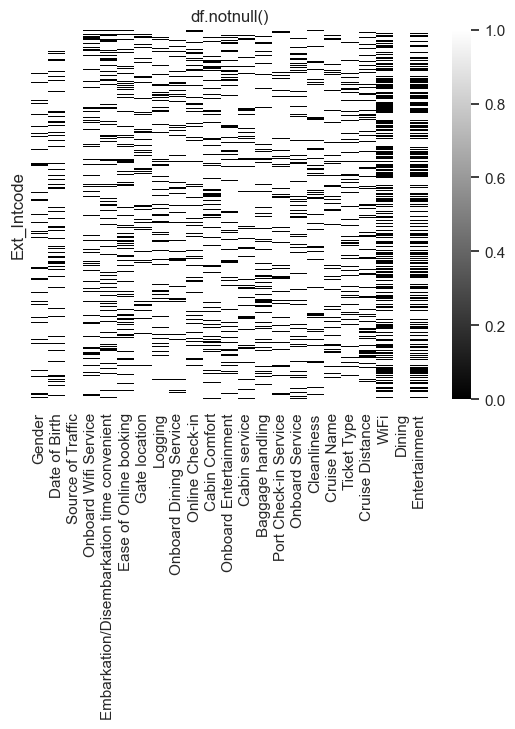

In [20]:
sns.heatmap(df.notnull(), cmap="gray", yticklabels=False)
plt.title("df.notnull()")
plt.show()

## 2.2 Univariate Distribution
Let's plot the distribution of each column separately, to get an overview of each which helps inform sampling and null-filling later.
- `Ticket Type`, our target variable, is very imbalanced. Only 6% of the dataset is of "Deluxe" tickets.  
  Thus, we should stratify when splitting the sample, or resample the data before training our model, or weight the classes appropriately during training.
- `Logging` and `Cruise Distance` are clearly not normally distributed.
- `WiFi`, `Dining`, and `Entertainment` are very uniformly distributed, which when taken with their nullity makes them arguably more suspicious.

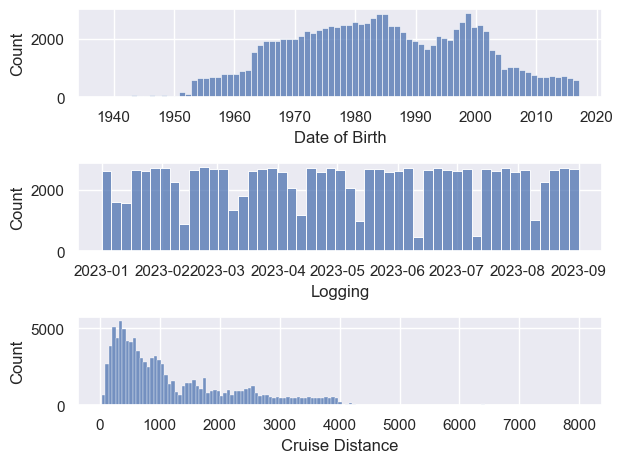

In [21]:
cols = cont_cols

fig, axs = plt.subplots(len(cols), 1)
for i, col in enumerate(cols):
    sns.histplot(df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()

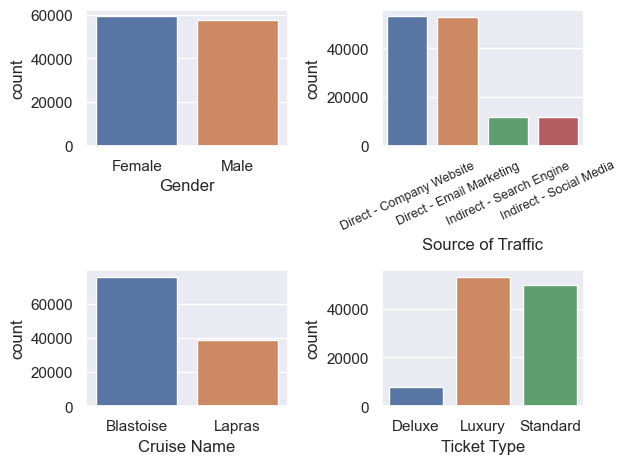

In [22]:
cols = nom_cols

fig, axs = plt.subplots((len(cols) + 1)//2, 2)
for i, col in enumerate(cols):
    sns.countplot(df, x=col, ax=axs[i//2, i%2])

axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=25, fontsize=9)
plt.tight_layout()
plt.show()

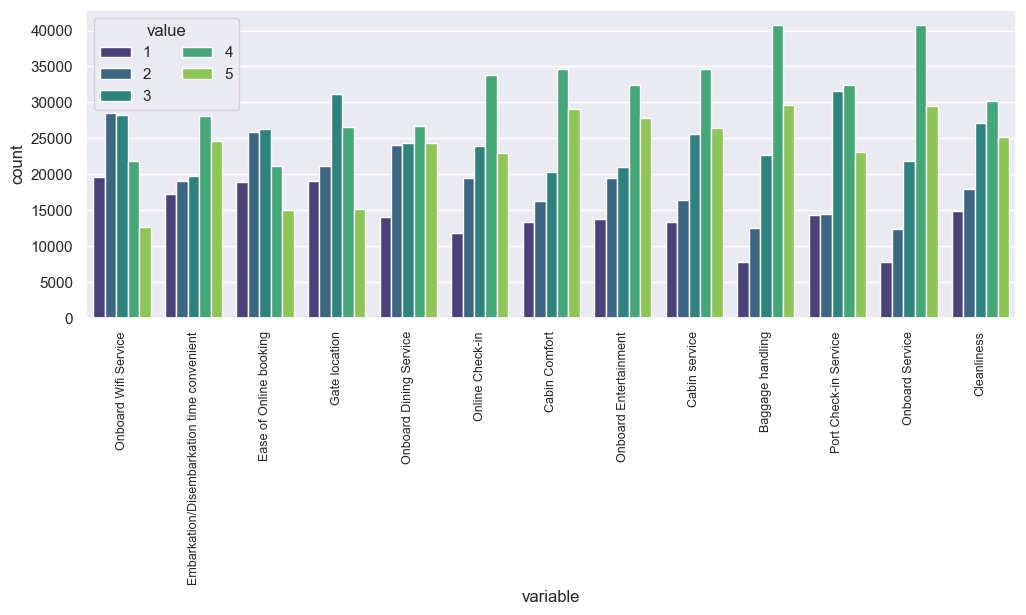

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df[pent_cols].melt().dropna(), x='variable', hue='value', ax=ax, palette="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
plt.legend(title="value", ncol=2)
plt.show()

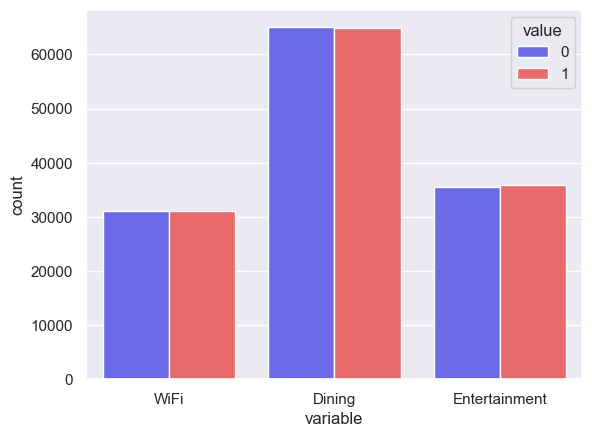

In [24]:
sns.countplot(df[bin_cols].melt().dropna(), x='variable', hue='value', palette='seismic')
plt.show()

## 2.3 Bivariate Correlation
We will calculate correlations between each pair of variables, to spot any interesting pairs that we can explore more in-depth later.  
- For continuous/ordinal pairs , we'll use Spearman's $\rho$
- For categorical pairs, we'll use Cramer's $V$
- To compare across continuous/ordinal and categorical, we'll use point-biserial coefficient between the one-hot encoded categortical variable and rank of the continuous/ordinal variable.

We chose to use Spearman's $\rho$ instead of Pearon's correlation because:
- We are more interested in spotting monotonic relations which we can still train non-linear ML model, than just spotting purely linear relations.
- A lot of the columns in the dataset are already ordinal, and casting the few continuous columns into ranks would allow us to analyse all of them together in a unified way.

These correlation measures are all normalised between -1 and 1, which indicate perfect negative and positive correlation respectively.  
However, each of these measures are different since they are meant to applied on different variable types, so we cannot generally compare across different measures.  

---

Notable observations are:
- Our target variable `Ticket Type` is strongly correlated to `Cruise Name`, `Cruise Distance` and the 13 pre-pruchase ratings.  
  Luxury ticket seems to be 1st class, then Deluxe, then Standard; since luxury ticket passengers have higher standards and go on longer cruises.  
- There is strong correlation within subsets of the 13 pre-pruchase ratings, suggests there are distinct customer archetypes concerned with convenience/activties/hospitality services.  
  We can try aggregating some of these ratings together, to identify each of these groups later in feature engineering.
- `Logging` is not correlated to anything. However, this is expected based on its description.
- `Wifi`, `Dining`, and `Entertainment` are not correlated with anything, not even among themselves.  
  All standard ticket holders also didn't have a rating for `WiFi` and `Entertainment`, and similarly deluxe tickets for `WiFi`.  
  This combined with their odd null value distribution, make it highly likely that these fields were randomly filled in and non-trustworthy.  

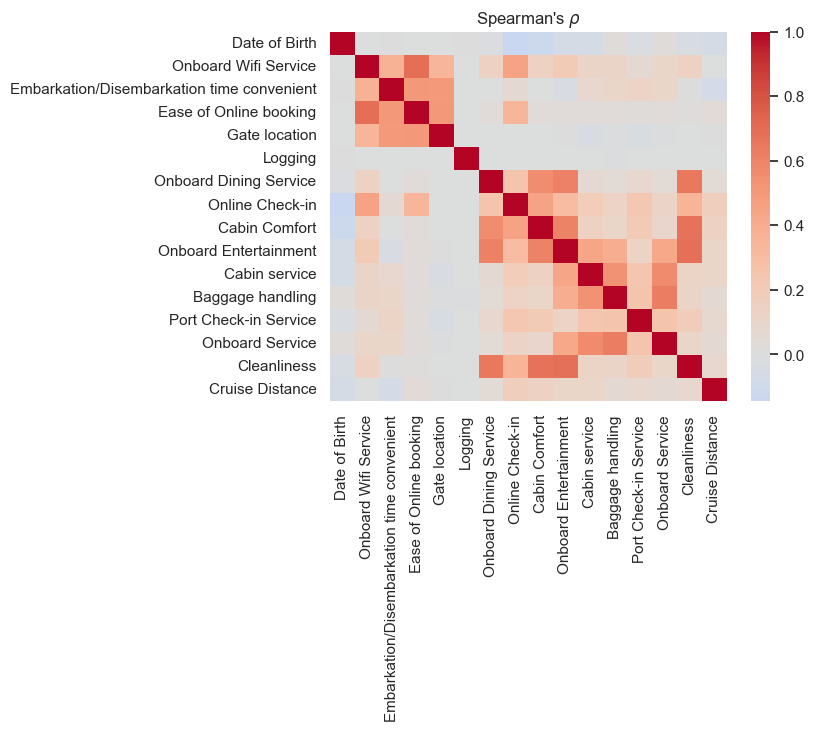

In [25]:
sns.heatmap(df.drop(columns=nom_cols+bin_cols).corr(method='spearman'), center=0, cmap='coolwarm')
plt.title(r"Spearman's $\rho$")
plt.show()

C:\Users\BillyLjm\Envs\aiap\Lib\site-packages\scipy\stats\contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
C:\Users\BillyLjm\Envs\aiap\Lib\site-packages\scipy\stats\contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)


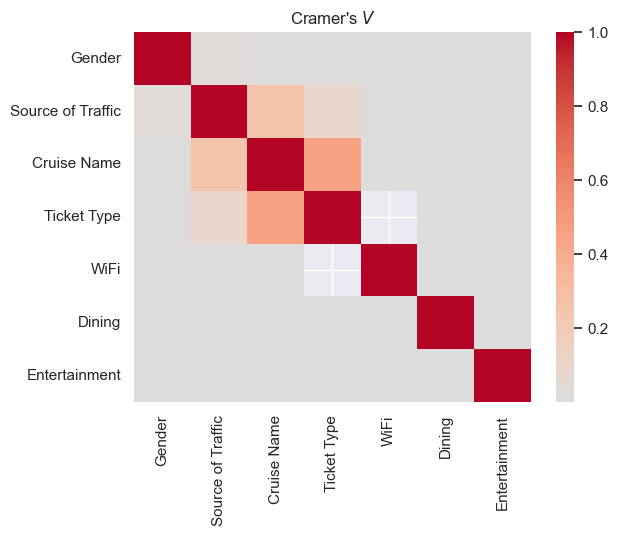

In [26]:
def cramer_v(df):
    """
    Calculate Cramer's V between each column in the dataframe

    :param df: pandas dataframe where each row correpsonds to one observation
    :return: pandas dataframe where df[coli][colj] = Kramer's V b/w coli and colj
    """
    mat = np.zeros((len(df.columns),)*2)
    for i, coli in enumerate(df.columns):
        for j, colj in enumerate(df.columns):
            crosstab = pd.crosstab(df[coli], df[colj])
            mat[i][j] = scipy.stats.contingency.association(crosstab, method="cramer")
    return pd.DataFrame(mat, index=df.columns, columns=df.columns)

sns.heatmap(cramer_v(df[nom_cols + bin_cols]), center=0, cmap='coolwarm')
plt.title(r"Cramer's $V$")
plt.show()

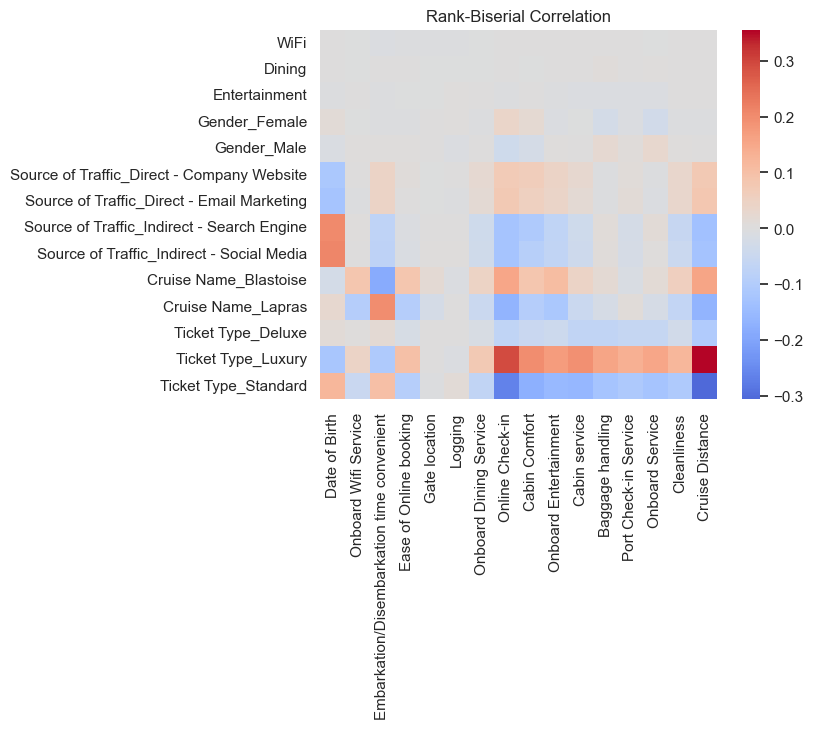

In [27]:
def rank_biserial(df, cat_cols):
    """
    Calculates the rank-biserial correlation coefficient b/w nominal and
    non-nominal columns in a dataset

    :param df: pandas dataframe of whole dataset
    :param cat_cols: list of categorical column name
    :return: dataframe where df[coli][colj] = point-biserial b/w coli and colj
    """
    cat = pd.get_dummies(df[cat_cols]) # one-hot encoding
    nocat = df.drop(columns=cat_cols)
    mat = np.zeros((len(cat.columns), len(nocat.columns)))
    for i, coli in enumerate(cat.columns):
        for j, colj in enumerate(nocat.columns):
            mask = cat[coli].notnull() & nocat[colj].notnull()
            mat[i][j] = scipy.stats.pointbiserialr(cat[coli][mask], 
                                                   nocat[colj][mask].rank())[0]
    return pd.DataFrame(mat, index=cat.columns, columns=nocat.columns)

sns.heatmap(rank_biserial(df, nom_cols+bin_cols), center=0, cmap='coolwarm')
plt.title(r"Rank-Biserial Correlation")
plt.show()

# 3. Feature Engineering
Having understood the dataset, we can manually engineer some features to help our ML model.
- We'll drop rows with null `Ticket Type`, since that is our target variable and we can't train without labels.
- We'll drop `Wifi`, `Dining`, and `Entertainment` since their trustworthines is suspect, and they don't correlate with anything.
- We'll drop `Logging` since it also doesn't correlate with anything.
- We'll take only the year from `Date of Birth`, since its range is pretty broad and keeping just the year should still give us enough granularity.
- We'll one-hot encode the categorical variables.
- We'll impute the null values, since most ML models don't support missing values
- We'll apply PCA (on rank/Spearman) on the 13 pre-purchase ratings, since they seem very promising for reducing the dimensionality of our dataset.   

These steps will eventually get grouped together into a sklearn pipeline and automatically executed when training and executing the model.  
But I'll do them manually here to give an idea of how they will work.  

In [28]:
# transform into feature, target variable
mask = df['Ticket Type'].notnull()
y  = df[mask]['Ticket Type']
X = df[mask].drop(columns=['Ticket Type'])

## 3.1 Dropping Columns
Dropping the columns/parts of columns that are useless, based on EDA above.  

In [29]:
class GetYear(BaseEstimator, TransformerMixin):
    """sklearn transformer to get year of datetime column"""
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self

    def transform(self, X, y=None):
        for col in X.columns:
            X[col] = X[col].dt.year.astype('Int64')
        return X
        
    def get_feature_names_out(self):
        return self.columns_

dropper = ColumnTransformer([
    ('drop', 'drop', ['Logging', 'WiFi', 'Dining', 'Entertainment']),
    ('year', GetYear(), ['Date of Birth'])
], remainder='passthrough')

dropper.set_output(transform='pandas')
dropper.fit_transform(X).head()

,year__Date of Birth,remainder__Gender,remainder__Source of Traffic,remainder__Onboard Wifi Service,remainder__Embarkation/Disembarkation time convenient,remainder__Ease of Online booking,remainder__Gate location,remainder__Onboard Dining Service,remainder__Online Check-in,remainder__Cabin Comfort,remainder__Onboard Entertainment,remainder__Cabin service,remainder__Baggage handling,remainder__Port Check-in Service,remainder__Onboard Service,remainder__Cleanliness,remainder__Cruise Name,remainder__Cruise Distance
Ext_Intcode,,,,,,,,,,,,,,,,,,
BL100AELMIT,1967,Male,Direct - Email Marketing,1,1,<NA>,1,5,5,5,4,4,4,<NA>,4,3,Blastoise,150.0
BL100AQXMUS,2001,NaN,Direct - Company Website,3,5,5,5,<NA>,<NA>,3,3,4,3,2,3,3,Blastoise,1464.0
BL100BAEEDV,<NA>,Male,Direct - Email Marketing,<NA>,4,<NA>,1,<NA>,<NA>,5,5,5,4,3,<NA>,5,Lapras,1733.0
BL100CNCWCN,1964,Female,Direct - Company Website,<NA>,<NA>,<NA>,5,4,5,3,5,5,5,<NA>,5,1,Blastoise,NaN
BL100DHMSHK,2002,Female,Indirect - Social Media,1,1,1,4,<NA>,1,3,3,3,4,3,<NA>,3,Blastoise,862.0


## 3.2 Data Imputing
Our data has a lot of uncorrelated null values, with 92% of rows having at least one null value.  
Thus, we can't drop all of them and instead have to impute these missing values.  

I'll use the a simple imputer to inpute the mean value for numerical/ordinal columns, and the most frequent values for the nominal columns.  
Hopefully, since these null values are distributed all over the dataframe, the imputation will not affect the correlations too much.  

In [30]:
imputer = ColumnTransformer([
    ('imputeMean', SimpleImputer(strategy='mean'), make_column_selector(dtype_include=np.number)),
    ('imputeFreq', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_exclude=np.number)),
], remainder='passthrough')

pl = Pipeline([('dropper', dropper), ('imputer', imputer)])
pl.set_output(transform='pandas')
pl.fit_transform(X).head()

,imputeMean__year__Date of Birth,imputeMean__remainder__Onboard Wifi Service,imputeMean__remainder__Embarkation/Disembarkation time convenient,imputeMean__remainder__Ease of Online booking,imputeMean__remainder__Gate location,imputeMean__remainder__Onboard Dining Service,imputeMean__remainder__Online Check-in,imputeMean__remainder__Cabin Comfort,imputeMean__remainder__Onboard Entertainment,imputeMean__remainder__Cabin service,imputeMean__remainder__Baggage handling,imputeMean__remainder__Port Check-in Service,imputeMean__remainder__Onboard Service,imputeMean__remainder__Cleanliness,imputeMean__remainder__Cruise Distance,imputeFreq__remainder__Gender,imputeFreq__remainder__Source of Traffic,imputeFreq__remainder__Cruise Name
Ext_Intcode,,,,,,,,,,,,,,,,,,
BL100AELMIT,1967.000000,1.000000,1.000000,2.881608,1.0,5.000000,5.000000,5.0,4.0,4.0,4.0,3.305275,4.000000,3.0,150.000000,Male,Direct - Email Marketing,Blastoise
BL100AQXMUS,2001.000000,3.000000,5.000000,5.000000,5.0,3.207231,3.327312,3.0,3.0,4.0,3.0,2.000000,3.000000,3.0,1464.000000,Female,Direct - Company Website,Blastoise
BL100BAEEDV,1983.592874,2.810429,4.000000,2.881608,1.0,3.207231,3.327312,5.0,5.0,5.0,4.0,3.000000,3.641218,5.0,1733.000000,Male,Direct - Email Marketing,Lapras
BL100CNCWCN,1964.000000,2.810429,3.221885,2.881608,5.0,4.000000,5.000000,3.0,5.0,5.0,5.0,3.305275,5.000000,1.0,1268.232985,Female,Direct - Company Website,Blastoise
BL100DHMSHK,2002.000000,1.000000,1.000000,1.000000,4.0,3.207231,1.000000,3.0,3.0,3.0,4.0,3.000000,3.641218,3.0,862.000000,Female,Indirect - Social Media,Blastoise


## 3.3 One-Hot Encoding
We'll one-hot encode the nominal categorical variables, to express their non-ordinality.  

In [31]:
ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False), make_column_selector(dtype_include='object')),
], remainder='passthrough')

pl = Pipeline([('dropper', dropper), ('imputer', imputer), ('ohe', ohe)])
pl.set_output(transform='pandas')
pl.fit_transform(X).head()

,ohe__imputeFreq__remainder__Gender_Male,ohe__imputeFreq__remainder__Source of Traffic_Direct - Company Website,ohe__imputeFreq__remainder__Source of Traffic_Direct - Email Marketing,ohe__imputeFreq__remainder__Source of Traffic_Indirect - Search Engine,ohe__imputeFreq__remainder__Source of Traffic_Indirect - Social Media,ohe__imputeFreq__remainder__Cruise Name_Lapras,remainder__imputeMean__year__Date of Birth,remainder__imputeMean__remainder__Onboard Wifi Service,remainder__imputeMean__remainder__Embarkation/Disembarkation time convenient,remainder__imputeMean__remainder__Ease of Online booking,remainder__imputeMean__remainder__Gate location,remainder__imputeMean__remainder__Onboard Dining Service,remainder__imputeMean__remainder__Online Check-in,remainder__imputeMean__remainder__Cabin Comfort,remainder__imputeMean__remainder__Onboard Entertainment,remainder__imputeMean__remainder__Cabin service,remainder__imputeMean__remainder__Baggage handling,remainder__imputeMean__remainder__Port Check-in Service,remainder__imputeMean__remainder__Onboard Service,remainder__imputeMean__remainder__Cleanliness,remainder__imputeMean__remainder__Cruise Distance
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,
BL100AELMIT,1.0,0.0,1.0,0.0,0.0,0.0,1967.000000,1.000000,1.000000,2.881608,1.0,5.000000,5.000000,5.0,4.0,4.0,4.0,3.305275,4.000000,3.0,150.000000
BL100AQXMUS,0.0,1.0,0.0,0.0,0.0,0.0,2001.000000,3.000000,5.000000,5.000000,5.0,3.207231,3.327312,3.0,3.0,4.0,3.0,2.000000,3.000000,3.0,1464.000000
BL100BAEEDV,1.0,0.0,1.0,0.0,0.0,1.0,1983.592874,2.810429,4.000000,2.881608,1.0,3.207231,3.327312,5.0,5.0,5.0,4.0,3.000000,3.641218,5.0,1733.000000
BL100CNCWCN,0.0,1.0,0.0,0.0,0.0,0.0,1964.000000,2.810429,3.221885,2.881608,5.0,4.000000,5.000000,3.0,5.0,5.0,5.0,3.305275,5.000000,1.0,1268.232985
BL100DHMSHK,0.0,0.0,0.0,0.0,1.0,0.0,2002.000000,1.000000,1.000000,1.000000,4.0,3.207231,1.000000,3.0,3.0,3.0,4.0,3.000000,3.641218,3.0,862.000000


## 3.4 Principal Component Analysis
We will apply PCA on the 13 pre-pruchase ratings, since EDA suggested subsets of them are highly correlated among themselves.  

The first 3 principal components were what were already spotted in the Spearman correlation matrix:
- PC1 is our activity archetype, mostly weighted in `Onboard Dining Service`, `Online Check-in`, `Cabin Comfort`, `Onboard Entertainment`.
- PC2 is our convenience archetype, mostly weighted in `Onboard Wifi Service`, `Embarkation/Disembarkation time convenient`, `Ease of Online booking`, `Gate location`.
- PC3 is our hospitality achetype, mostly weighted in `Cabin service`, `Baggage handling`, `Port Check-in Service`, `Onboard Service`.

Based on this, we will keep the first 5 principal components (out of the 13 pre-pruchase ratings), which already explains 80% of the Spearman correlation.

In [32]:
pca = PCA(n_components = 10)
pca.fit(df[pent_cols].dropna())
pca.explained_variance_ratio_

array([0.29220123, 0.19685979, 0.14512509, 0.07711402, 0.06948276,
       0.03856921, 0.03809163, 0.03403638, 0.02655578, 0.02289517])

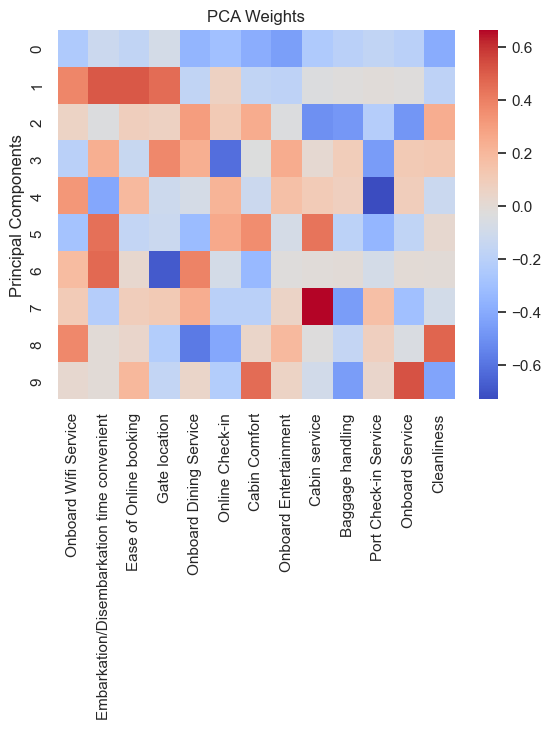

In [33]:
sns.heatmap(pca.components_, cmap='coolwarm', xticklabels=pent_cols)
plt.ylabel("Principal Components")
plt.title("PCA Weights")
plt.show()

In [34]:
pca = ColumnTransformer([
    ('pca', PCA(n_components = 5), ['remainder__imputeMean__remainder__' + i for i in pent_cols]),
], remainder='passthrough')

pl = Pipeline([('dropper', dropper), ('imputer', imputer), ('ohe', ohe), ('pca', pca)])
pl.set_output(transform='pandas')
pl.fit_transform(X).head()

,pca__pca0,pca__pca1,pca__pca2,pca__pca3,pca__pca4,remainder__ohe__imputeFreq__remainder__Gender_Male,remainder__ohe__imputeFreq__remainder__Source of Traffic_Direct - Company Website,remainder__ohe__imputeFreq__remainder__Source of Traffic_Direct - Email Marketing,remainder__ohe__imputeFreq__remainder__Source of Traffic_Indirect - Search Engine,remainder__ohe__imputeFreq__remainder__Source of Traffic_Indirect - Social Media,remainder__ohe__imputeFreq__remainder__Cruise Name_Lapras,remainder__remainder__imputeMean__year__Date of Birth,remainder__remainder__imputeMean__remainder__Cruise Distance
Ext_Intcode,,,,,,,,,,,,,
BL100AELMIT,-1.505632,-3.127346,0.016255,-1.471594,0.975560,1.0,0.0,1.0,0.0,0.0,0.0,1967.000000,150.000000
BL100AQXMUS,0.157557,3.101709,0.822034,1.348504,0.407025,0.0,1.0,0.0,0.0,0.0,0.0,2001.000000,1464.000000
BL100BAEEDV,-2.449858,-1.282371,-0.448452,0.136444,0.257509,1.0,0.0,1.0,0.0,0.0,1.0,1983.592874,1733.000000
BL100CNCWCN,-1.424630,1.180877,-2.250830,0.478566,1.087761,0.0,1.0,0.0,0.0,0.0,0.0,1964.000000,1268.232985
BL100DHMSHK,1.993843,-2.471856,-0.486257,1.913185,-0.410156,0.0,0.0,0.0,0.0,1.0,0.0,2002.000000,862.000000


## 3.5 Full Pre-Processing
We can concatenate all the steps above into the full pre-processing pipeline.  

In [35]:
preprocess = Pipeline([
    ('dropper', ColumnTransformer([
        ('drop', 'drop', ['Logging', 'WiFi', 'Dining', 'Entertainment']),
        ('year', GetYear(), ['Date of Birth'])
    ], remainder='passthrough')),
    ('imputer', ColumnTransformer([
        ('imputeMean', SimpleImputer(strategy='mean'), make_column_selector(dtype_include=np.number)),
        ('imputeFreq', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_exclude=np.number)),
    ], remainder='passthrough')),
    ('encode', ColumnTransformer([
        ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False), make_column_selector(dtype_include='object')),
        ('pca', PCA(n_components = 5), ['imputeMean__remainder__' + i for i in pent_cols]),
    ], remainder='passthrough'))
])

preprocess.set_output(transform='pandas')
preprocess.fit_transform(X).head()

,ohe__imputeFreq__remainder__Gender_Male,ohe__imputeFreq__remainder__Source of Traffic_Direct - Company Website,ohe__imputeFreq__remainder__Source of Traffic_Direct - Email Marketing,ohe__imputeFreq__remainder__Source of Traffic_Indirect - Search Engine,ohe__imputeFreq__remainder__Source of Traffic_Indirect - Social Media,ohe__imputeFreq__remainder__Cruise Name_Lapras,pca__pca0,pca__pca1,pca__pca2,pca__pca3,pca__pca4,remainder__imputeMean__year__Date of Birth,remainder__imputeMean__remainder__Cruise Distance
Ext_Intcode,,,,,,,,,,,,,
BL100AELMIT,1.0,0.0,1.0,0.0,0.0,0.0,-1.505632,-3.127346,0.016255,-1.471594,0.975560,1967.000000,150.000000
BL100AQXMUS,0.0,1.0,0.0,0.0,0.0,0.0,0.157557,3.101709,0.822034,1.348504,0.407025,2001.000000,1464.000000
BL100BAEEDV,1.0,0.0,1.0,0.0,0.0,1.0,-2.449858,-1.282371,-0.448452,0.136444,0.257509,1983.592874,1733.000000
BL100CNCWCN,0.0,1.0,0.0,0.0,0.0,0.0,-1.424630,1.180877,-2.250830,0.478566,1.087761,1964.000000,1268.232985
BL100DHMSHK,0.0,0.0,0.0,0.0,1.0,0.0,1.993843,-2.471856,-0.486257,1.913185,-0.410156,2002.000000,862.000000


# 4. Model Selection
This is a multi-class classification problem, and we are specified to train 3 different ML models for it, which we've selected to be
- Support vector machine, as a simple model
- Random forests, as an ensemble method to minimise variance
- Gradient-boosted trees, as an ensemble method to reduce bias

In optimising each of these models, we will use:
- grid search to optimise the hyperparameters for each of the 3 models.  
- k-fold stratified cross validation to minimise variance in our trained model
- F1-macro score, to more equally weight all 3 ticket types despite their imbalance

However, as specified in the assignment instructions, these will all be done outside of these notebooks, as python files in `/src`